In [1]:
# imports
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split


## Step 1: Load In Training Dataset

In [2]:
# Read in cars and notcars
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]
print(len(cars)+len(notcars))


17760


In [3]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 600] # Min and max in y to search in slide_window()
y_start_stop_up = [400, 450] # Min and max in y to search in slide_window() for upper half
y_start_stop_down = [450, 600] # Min and max in y to search in slide_window() for lower half

## Step 2:  Exploration

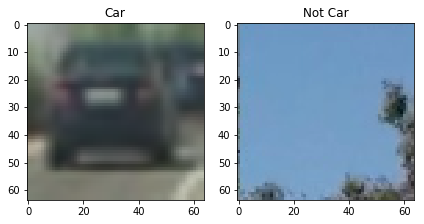

In [4]:
# display a image of car and a image of not car
car_img = mpimg.imread(cars[0])
not_car_img = mpimg.imread(notcars[0])

%matplotlib inline
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car')
plt.subplot(122)
plt.imshow(not_car_img, cmap='hot')
plt.title('Not Car')
fig.tight_layout()


In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


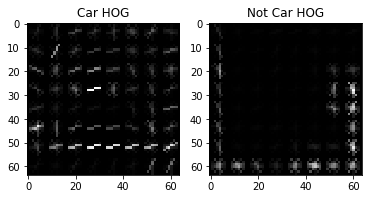

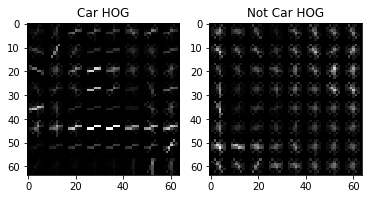

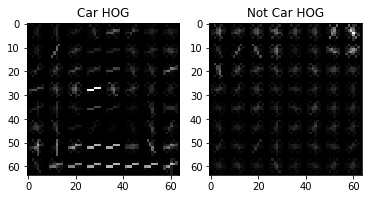

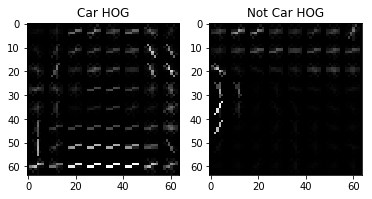

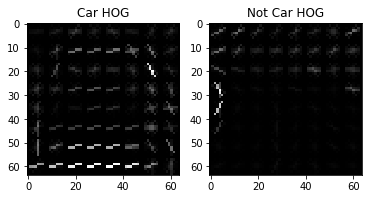

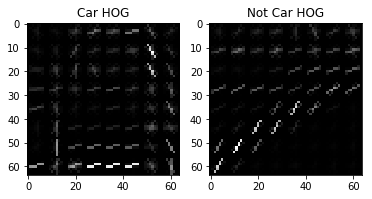

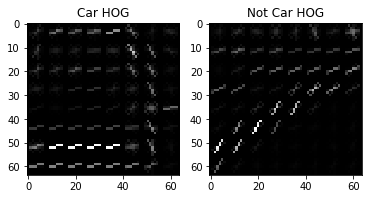

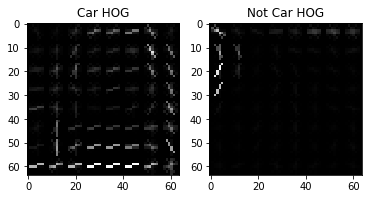

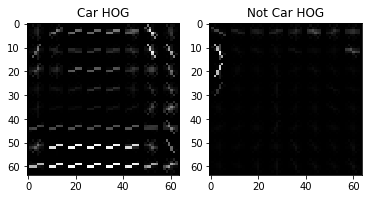

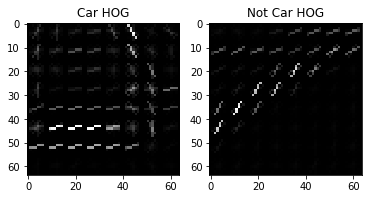

In [6]:
# extract the HOG feature of car and not car

# load 10 images of cars and notcars so that it is easy to see whether the parameter chosen 
# demonstrates the consistency of HOG features for car images
car_imgs = [mpimg.imread(car) for car in cars[0:10]]
not_car_imgs = [mpimg.imread(car) for car in notcars[0:10]]


# convert the car and not car image into grayscale
for i, (car_img, not_car_img) in enumerate(zip(car_imgs, not_car_imgs)):
    gray_car = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
    gray_not_car = cv2.cvtColor(not_car_img, cv2.COLOR_RGB2GRAY)

    features_car, hog_image_car = get_hog_features(gray_car, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)

    features_not_car, hog_image_not_car = get_hog_features(gray_not_car, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)




    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(hog_image_car, cmap='gray')
    plt.title('Car HOG')
    plt.subplot(122)
    plt.imshow(hog_image_not_car, cmap='gray')
    plt.title('Not Car HOG')
    plt.savefig("output_images/HOG-analysis-{}.jpg".format(i))


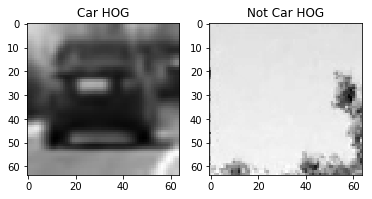

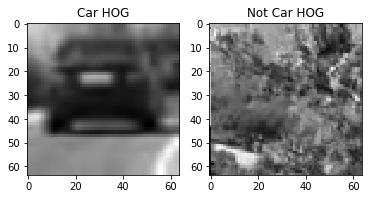

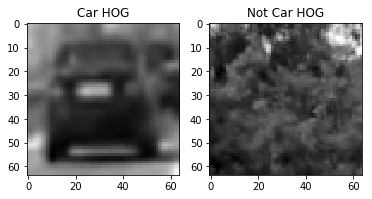

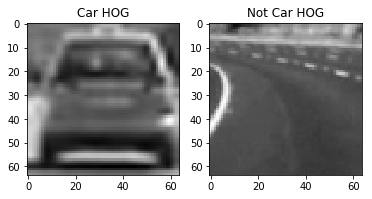

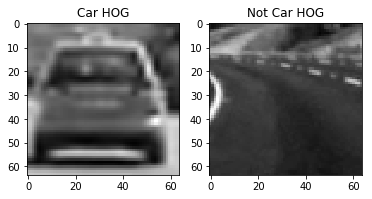

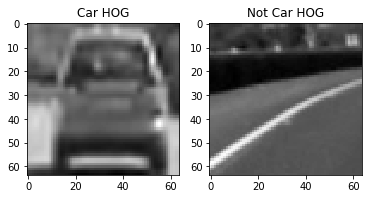

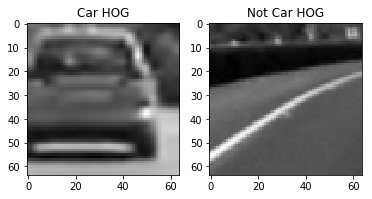

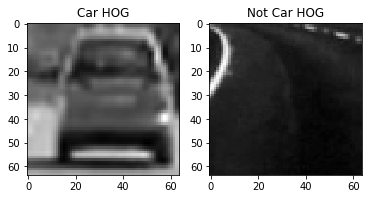

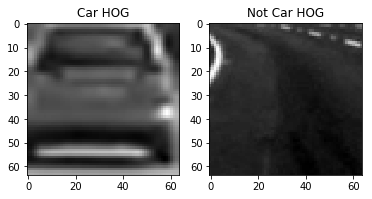

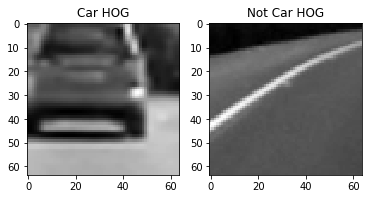

In [7]:
# extract the color feature 
for car_img, not_car_img in zip(car_imgs, not_car_imgs):
    feature_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2YCrCb)
    feature_not_car_img = cv2.cvtColor(not_car_img, cv2.COLOR_RGB2YCrCb)
    car_y = feature_car_img[:,:,0]
    car_cr = feature_car_img[:,:,1]
    car_cb = feature_car_img[:,:,2]
    not_car_y = feature_not_car_img[:,:,0]
    not_car_cr = feature_not_car_img[:,:,1]
    not_car_cb = feature_not_car_img[:,:,2]
    
    
    # Plot the examples
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(car_y, cmap="gray")
    plt.title('Car HOG')
    plt.subplot(122)
    plt.imshow(not_car_y,cmap="gray")
    plt.title('Not Car HOG')
    

## Step 3 : Train the classifier

In [8]:
# Train the classifier
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()



/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
13.81 Seconds to train SVC...
Test Accuracy of SVC =  0.9789


## Step 4: Detect Cars

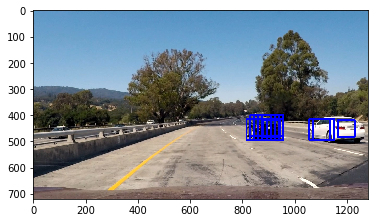

In [25]:
# Using baseline approach
# test image
image = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255


# first, add search window of size 64 in order to search farther cars 
windows_far = slide_window(image, x_start_stop=[500, None], y_start_stop=[400,500], 
                xy_window=(64, 64), xy_overlap=(0.7, 0.7))
# then, add search window of size 80 in order to search closer cars
windows_close = slide_window(image, x_start_stop=[500, None], y_start_stop=[400,500], 
                xy_window=(80, 80), xy_overlap=(0.8, 0.8))

windows = [*windows_far, *windows_close]

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)  

# print(windows)


# window_img = draw_boxes(draw_image, windows_close, color=(0, 255, 0), thick=6)
# window_img = draw_boxes(window_img, windows_far, color=(0, 0, 255), thick=6)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
cv2.imwrite("output_images/detect_cars.jpg", window_img)

%matplotlib inline
plt.imshow(window_img)




## Step 5: Use Heat Map to get single larger bounding boxes

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

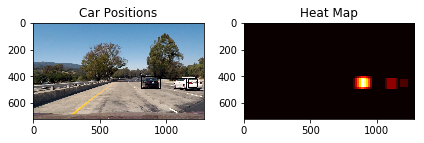

In [12]:
from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,0)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)
cv2.imwrite("output_images/final_result.jpg", draw_img)

%matplotlib inline
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Step 6: One-functionize

In [27]:
# make this useable for the image function when doing video analysis
from scipy.ndimage.measurements import label
import itertools
def find_cars_in_image(img, bb = None):
    # perhaps this is not correct for MPG images
    
    img = img.astype(np.float32) / 255
    draw_img = np.copy(img)
    
    
    # doing multiple window search
    # because the car is at the most left lane for all the test images and videos, 
    # it is easy to eliminate some of the false positives just by cutting off all the left region
    # However, this will not be a valid solution if the car is not at the left
    
    # first, add search window of size 64 in order to search farther cars 
    windows_far = slide_window(img, x_start_stop=[400, None], y_start_stop=[400,500], 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
    # then, add search window of size 80 in order to search closer cars
    windows_close = slide_window(img, x_start_stop=[400, None], y_start_stop=[400,500], 
                    xy_window=(80, 80), xy_overlap=(0.8, 0.8))
    
    windows = [*windows_far, *windows_close]

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)  
    
    # add previous detections
    this_detection = hot_windows
    if bb is not None:
        hot_windows = [*hot_windows, *list(itertools.chain(*bb.bboxes))]
    
    # print(windows)

    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6) 
    
#     _, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives, this is for the cumulative threshold for all the recent detections
    # only apply this if the frame passed is greater than the maximum size of the bb class
    
    # if this is used for image detection, use a threshold of 1
    if bb == None:
        heat = apply_threshold(heat, 0)
    # else, use the maximum capacity of bbox as the threshold ( which means at least 1 detection per frame )
    elif len(bb.bboxes) < bb.max_frame:
        heat = apply_threshold(heat, len(bb.bboxes))
    else:
        heat = apply_threshold(heat, bb.max_frame)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    

    
    return draw_img , heatmap, window_img, this_detection
    

In [14]:
class BoundingBoxes:
    def __init__(self, max_frame = 6):
        self.bboxes = []  # a list of recently discovered bounding boxes. This should be 2D
        self.max_frame = max_frame # maximum frames of bboxes to store
        
    def add_bboxes(self, bboxes):
        # if there are less than the maximum frames stored, add in
        if len(self.bboxes) < self.max_frame:
            self.bboxes.append(bboxes)
        # else, pop the first one
        else:
            self.bboxes.pop(0)
            self.bboxes.append(bboxes)
            

In [15]:
def find_cars_all_in_one(img, mode = "video"):
    if mode == "image":
        return find_cars_in_image(img)[0]
    # need to deal with previous results later
    else:
        result, _, _, current = find_cars_in_image(img, bb)
        bb.add_bboxes(current)
        return result * 255
    
    

## Step 7: Apply heat map on time domain ( consecutive frames )

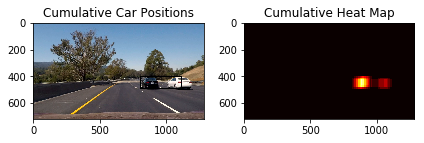

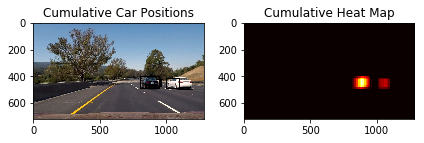

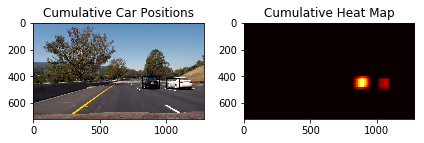

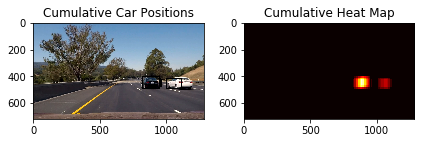

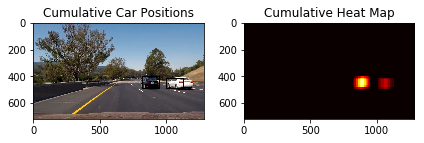

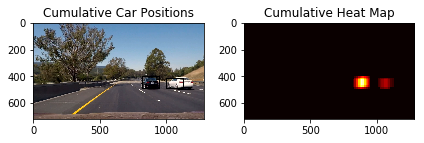

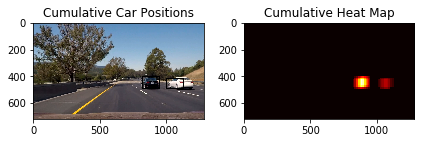

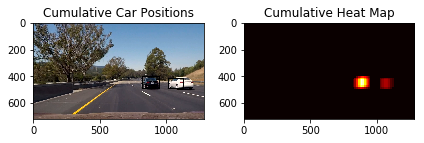

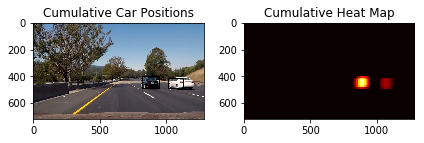

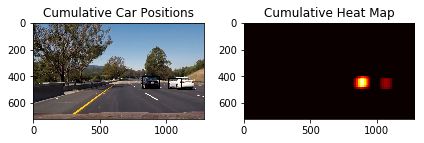

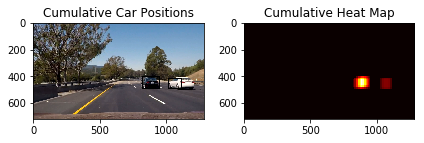

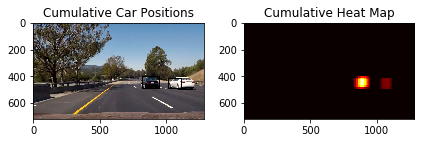

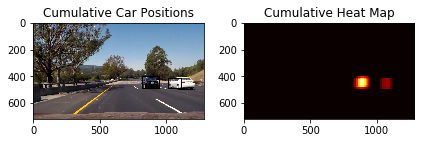

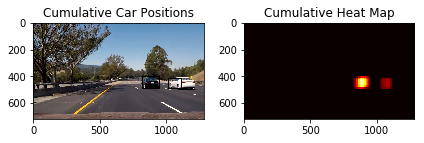

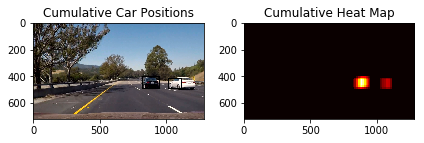

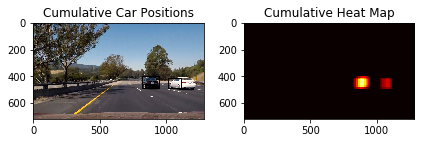

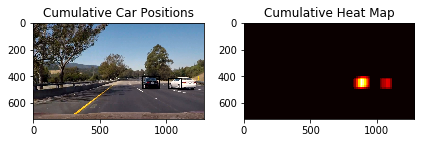

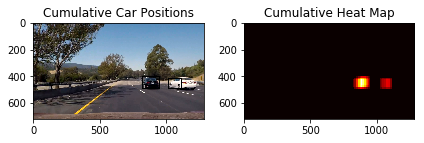

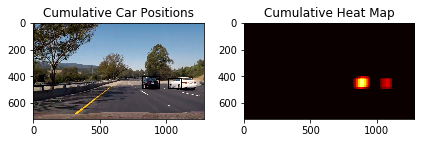

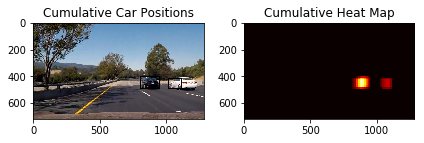

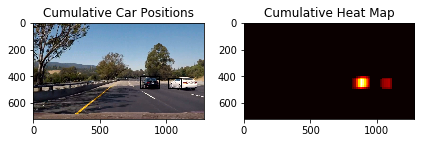

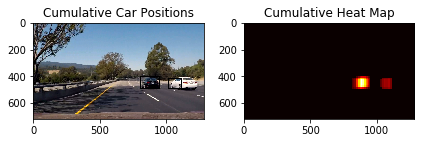

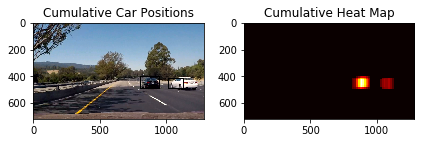

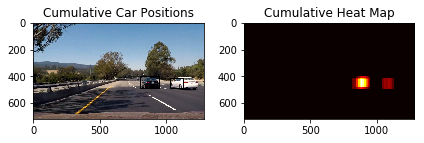

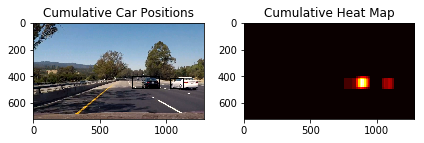

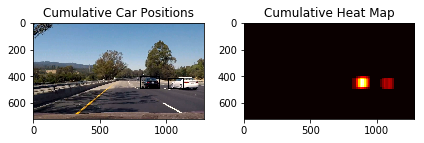

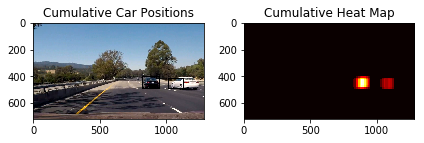

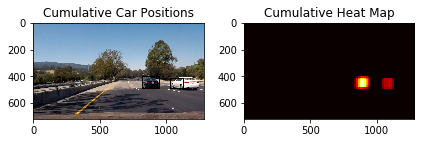

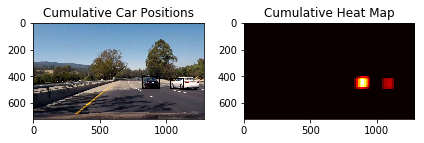

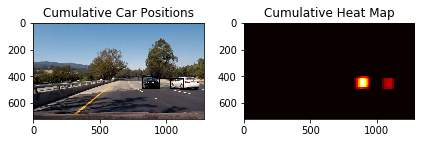

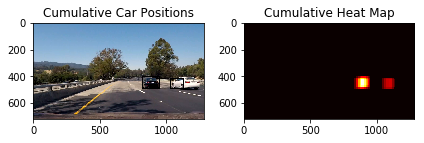

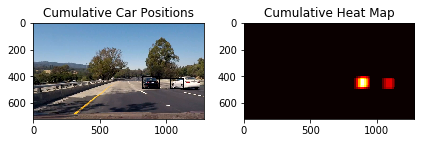

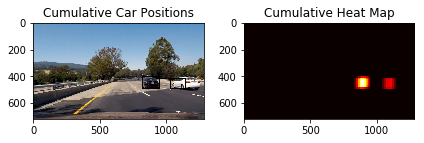

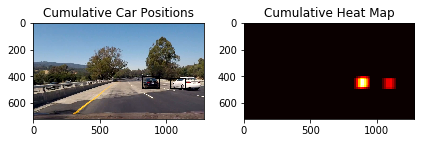

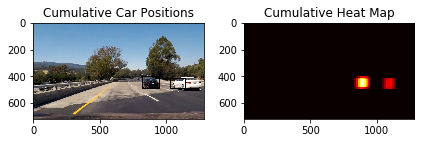

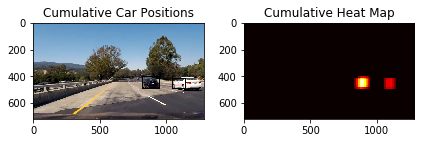

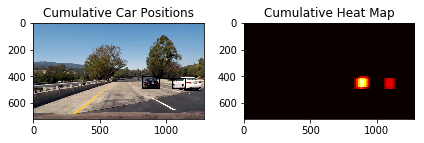

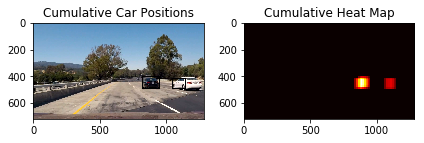

In [29]:
# be patient, this block of code is EXTREMELY SLOW to run.

from moviepy.editor import VideoFileClip
# load all the frames from test video
clip_test = VideoFileClip('test_video.mp4')
%matplotlib inline
bb = BoundingBoxes()
for frame in clip_test.iter_frames():
    _, heatmap, window_img, boxes = find_cars_in_image(frame)
    result_cumulative, heatmap_cumulative, window_img_cumulative, _= find_cars_in_image(frame, bb)
    bb.add_bboxes(boxes)
    
#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(window_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()
    
    #9
    
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(result_cumulative, cmap='hot')
    plt.title('Cumulative Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap_cumulative, cmap='hot')
    plt.title('Cumulative Heat Map')
    fig.tight_layout()

## Step 8: Use the function to test multiple images

In [18]:
from tqdm import tqdm
test_imgs = glob.glob("test_images/*.jpg")
for img_path in tqdm(test_imgs):
    img = mpimg.imread(img_path)
    img = find_cars_all_in_one(img, mode="image") 
    path = img_path.split("/")[1]
    mpimg.imsave("output_images/96_{}".format(path), img)

100%|██████████| 6/6 [00:06<00:00,  1.13s/it]


## Step 9: Use the function on video

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

# Load the video
yellow_output = 'output_harder_challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('harder_challenge_video.mp4')
bb = BoundingBoxes(30) # use 10 for detecting opposite lane, 30 for lanes driving in the same direction
yellow_clip = clip2.fl_image(find_cars_all_in_one)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video output_harder_challenge_video.mp4
[MoviePy] Writing video output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [07:27<00:00,  2.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge_video.mp4 

CPU times: user 7min 10s, sys: 15.3 s, total: 7min 26s
Wall time: 7min 27s
